In [113]:
import itertools
import json
import pickle
import string
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_curve

from nltk.corpus import stopwords


# Helper Functions

In [126]:
# Some global variables to help the helper functions
table = str.maketrans({key: None for key in string.punctuation})
english_stopwords = stopwords.words('english')
for n,stopword in enumerate(english_stopwords):
    english_stopwords[n] = stopword.translate(table).lower()
english_stopwords = set(english_stopwords)

def clean_tweet(tweet):
    # Split by white space
    words = tweet.split()
    # Remove anything with "@", "t.co","&"
    for n,word in enumerate(words):
        if "@" in word or "t.co" in word:# or "&" in word:
            words[n] = ""
        else:
            # Remove punctuation and lowercase
            words[n] = word.translate(table).lower()
            # Check if clean word in clean stopword set
            if words[n] in english_stopwords or not words[n].isalnum():
                words[n] = ""
            
    clean_tweet = " ".join(filter(None,words))
    return clean_tweet

def print_metrics(truth,pred):
    print('Accuracy: ' + str(metrics.accuracy_score(truth, pred)))
    print('Precision: ' + str(metrics.precision_score(truth, pred)))
    print('Recall: ' + str(metrics.recall_score(truth, pred)))
    print('F-1 Score: ' + str(metrics.f1_score(truth, pred)))
    
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          classes = ['Massachussetts', 'Washington']
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def roc_plotter(model, data, labels, clfType):
    if clfType == "LogisticRegression":
        scores = model.decision_function(data)
    elif clfType in ["RandomForest","NaiveBayes"]:
        scores = model.predict_log_proba(data)[:,1]
    else:
        print("Invalid clfType.")
        return
    fpr, tpr, thresholds = roc_curve(labels,scores)
    plt.plot(fpr,tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

# Generate Location-Based Dataset

In [49]:
DATA_DIRECTORY = "ECE219_tweet_data/"
filenames = ["tweets_#superbowl.txt"]

MASSACHUSETTS_FLAGS = ["Massachusetts","Boston","MA"]
WASHINGTON_FLAGS = ["Washington","Seattle","WA"]

tweetLocationDataset = []

with open(DATA_DIRECTORY+filenames[0]) as f:
    for line in f:
        json_tweet = json.loads(line)
        location = json_tweet['tweet']['user']['location']
        locationFoundFlag = False
        for m in MASSACHUSETTS_FLAGS:
            if m in location:
                locationFoundFlag = True
                tweetLocationDataset.append((json_tweet['tweet']['text'],"MA"))
                break
        if not locationFoundFlag:
            for w in WASHINGTON_FLAGS:
                if w in location:
                    locationFoundFlag = True
                    tweetLocationDataset.append((json_tweet['tweet']['text'],"WA"))
                                        
with open('locationBasedDataset.pickle', 'wb') as handle:
    pickle.dump(tweetLocationDataset, handle)


# Load Data If Already Generated

In [59]:
with open('locationBasedDataset.pickle','rb') as handle:
    tweetLocationDataset = pickle.load(handle)
    
data = np.array(tweetLocationDataset)

# Pre-Process Tweets

In [60]:
print("Number of Massachusetts tweets: %d" % sum(data[:,1] == "MA"))
print("Number of Washington tweets:    %d" % sum(data[:,1] == "WA"))

clean_data = set()

for i in range(len(data)):
    tweet = data[i,0]
    clean_data.add((clean_tweet(tweet),data[i,1]))
clean_data = list(clean_data)
clean_data = np.array(clean_data)
np.random.shuffle(clean_data)
    
print("\nNumber of Unique Massachusetts tweets: %d" % sum(clean_data[:,1] == "MA"))
print("Number of Unique Washington tweets:    %d" % sum(clean_data[:,1] == "WA"))

print("\nCleaned Data Samples With Labels\n")
for i in range(100):
    print("Location " + clean_data[i,1] + ": " + clean_data[i,0])

Number of Massachusetts tweets: 21195
Number of Washington tweets:    32441

Number of Unique Massachusetts tweets: 20186
Number of Unique Washington tweets:    25502

Cleaned Data Samples With Labels

Location WA: lds worldcup obama sounders cr7 mufc stock soccer twitterstake snrtg uk
Location WA: curious talking cheatriots today ok cheaters superbowlxlix deflategate
Location WA: toyota dadad waaay better nissans showed consistent presence followthrough adbowl superbowlsunday
Location WA: pete carroll discuss superbowls last play matt lauer via seahawks nfl
Location MA: bad im boston im watching superbowlxlix right gopats im rooting room
Location MA: keep lead finish job superbowlxlix
Location MA: sports questions credibility heading superbowl
Location WA: pass intercepted would make call handed one mistake superbowlxlix
Location MA: ridiculous superbowl ever watched life gopats
Location WA: saw android commercial better superbowl
Location WA: happens option watch ot work superbowlbou

In [122]:
SPLIT_TRAIN_RATIO = 0.8
splitIndex = int(vectorized_tweets.shape[0]*SPLIT_TRAIN_RATIO)

vectorizer = TfidfVectorizer(min_df=15)
vectorized_tweets_train = vectorizer.fit_transform(clean_data[:splitIndex,0])
vectorized_tweets_test = vectorizer.transform(clean_data[splitIndex:,0])
binarized_labels = clean_data[:,1].copy()
for n,label in enumerate(binarized_labels):
    if label == "MA":
        binarized_labels[n] = 0
    else:
        binarized_labels[n] = 1
        
y_train = binarized_labels[:splitIndex].astype('int')
y_test = binarized_labels[splitIndex:].astype('int')
print("Vectorized Tweets Train shape: " + str(vectorized_tweets_train.shape))

Vectorized Tweets Train shape: (36675, 2079)


In [90]:
x_train = vectorized_tweets_train
x_test = vectorized_tweets_test

Accuracy: 0.727393764562
Precision: 0.714581178904
Recall: 0.838083687083
F-1 Score: 0.771420597265


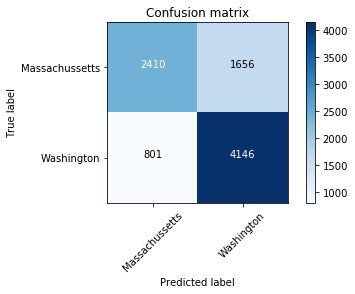

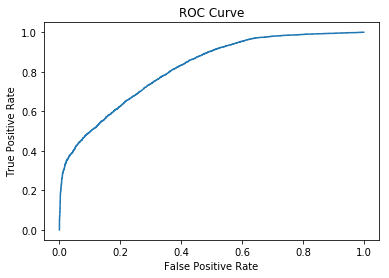

In [130]:
LogisticRegressionClassifier = LogisticRegression()
LogisticRegressionClassifier.fit(x_train,y_train)
train_predictions = LogisticRegressionClassifier.predict(x_train)
test_predictions = LogisticRegressionClassifier.predict(x_test)

print_metrics(y_test,test_predictions)
plot_confusion_matrix(confusion_matrix(y_test,test_predictions))
roc_plotter(LogisticRegressionClassifier,x_test,y_test,clfType="LogisticRegression")

Accuracy: 0.715965827139
Precision: 0.676893434119
Recall: 0.923185769153
F-1 Score: 0.781084316744


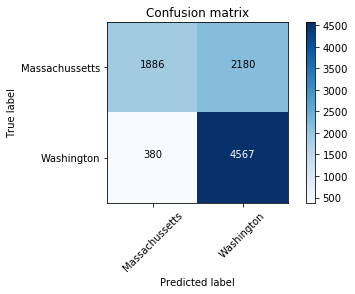

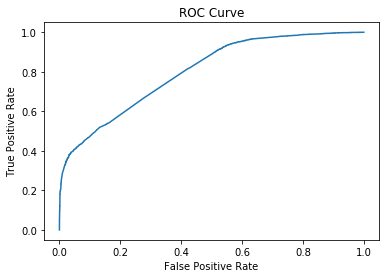

In [128]:
rfc = RandomForestClassifier(max_depth=30)
rfc.fit(x_train,y_train)
train_predictions = rfc.predict(x_train)
test_predictions = rfc.predict(x_test)

print_metrics(y_test,test_predictions)
plot_confusion_matrix(confusion_matrix(y_test,test_predictions))
roc_plotter(rfc,x_test,y_test,clfType="RandomForest")

Accuracy: 0.620548097193
Precision: 0.72990063234
Recall: 0.489993935719
F-1 Score: 0.586357039187


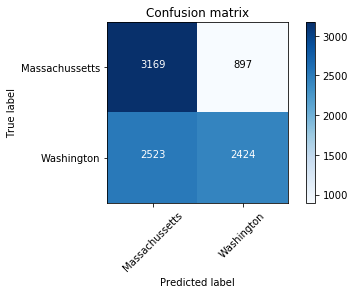

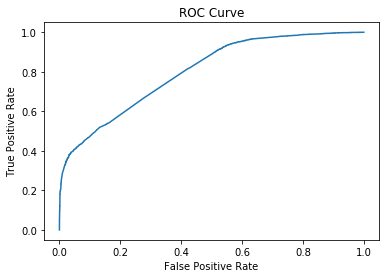

In [131]:
nb = GaussianNB()
nb.fit(x_train.toarray(),y_train)
train_predictions = nb.predict(x_train.toarray())
test_predictions = nb.predict(x_test.toarray())

print_metrics(y_test,test_predictions)
plot_confusion_matrix(confusion_matrix(y_test,test_predictions))
roc_plotter(rfc,x_test,y_test,clfType="NaiveBayes")